## Import Essential Libraries

In [2]:
import sys
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns
import collections
import hashlib

time_to_date = lambda t: datetime.utcfromtimestamp(t).strftime('%Y-%m-%d %H:%M:%S')

## Import Device Data

In [33]:
devices_ip = []
devices_mac = []

filepath = '../annotations/device_info.csv'
device_info = pd.read_csv(filepath, index_col=None, delimiter=',')

devices_ip = device_info['ip'].to_list()
devices_mac = device_info['mac'].to_list()
device_info

,mac,ip,device_type
0,ec:1a:59:83:28:11,192.168.1.165,WEMO Motion Sensor
1,ec:1a:59:79:f4:89,192.168.1.223,WEMO Power Switch
2,00:16:6c:ab:6b:88,192.168.1.248,Samsung Camera
3,50:c7:bf:00:56:39,192.168.1.227,TP Link Plug
4,70:ee:50:18:34:43,192.168.1.241,Netatmo Camera
5,00:17:88:2B:9A:25,192.168.1.129,Huebulb
6,44:65:0D:56:CC:D3,192.168.1.239,AmazonEcho
7,F4:F5:D8:8F:0A:3C,192.168.1.119,chromecast
8,74:C6:3B:29:D7:1D,192.168.1.163,ihome
9,D0:73:D5:01:83:08,192.168.1.118,lifx


## Import Attack Annotations

In [66]:
times = []
annotation_files_folder = '../annotations'

for filename in os.listdir(annotation_files_folder):
  with open(os.path.join(annotation_files_folder, filename), 'r') as f:
    for line in f.readlines():
      values = line.strip().split(',')

      try:
        start_value = float(values[0])
        end_value = float(values[1])
        times.append((start_value, end_value))
      except:
        continue

print("Done with annotations")

Done with annotations


## Import Flows

In [147]:
times_pcap = []
addresses = devices_ip + devices_mac

filepath = '/home/faizan/dalhousie/181021-3.csv'
attack_flows = pd.read_csv(filepath, index_col=None, delimiter=',')

for index, flow in attack_flows.iterrows():
    strt_time = float(flow.StartTime)
    dur = float(flow.Dur)
    end_time = strt_time + dur

    if flow.SrcAddr in addresses or flow.DstAddr in addresses:
        times_pcap.append((index, strt_time, end_time))

attack_flows


,StartTime,Dur,Flgs,Proto,SrcAddr,Sport,Dir,DstAddr,Dport,TotPkts,...,DIntPktIdl,SrcJitter,DstJitter,sMeanPktSz,dMeanPktSz,sMaxPktSz,dMaxPktSz,sMinPktSz,dMinPktSz,Label
0,1.540040e+09,4.066716,e,eapol,14:cc:20:51:33:e9,NaN,<->,ec:1a:59:7a:02:c5,NaN,6,...,0.0,1028.698500,1025.152500,113.0,137.0,113.0,137.0,113.0,137.0,NaN
1,1.540040e+09,2.759746,e,eapol,14:cc:20:51:33:e8,NaN,<->,30:8c:fb:2f:e4:b2,NaN,5,...,0.0,621.083000,0.000000,135.0,113.0,135.0,113.0,135.0,113.0,NaN
2,1.540040e+09,4.406374,e,eapol,14:cc:20:51:33:e9,NaN,<->,70:5a:0f:e4:9b:c0,NaN,8,...,0.0,410.688281,417.422469,113.0,135.0,113.0,135.0,113.0,135.0,NaN
3,1.540040e+09,4.993716,e,eapol,14:cc:20:51:33:e9,NaN,<->,f4:f2:6d:93:51:f1,NaN,5,...,0.0,496.311000,0.000000,113.0,135.0,113.0,135.0,113.0,135.0,NaN
4,1.540040e+09,0.000000,*,llc,b4:75:0e:ec:e5:a9,0x01,->,Broadcast,NaN,1,...,NaN,NaN,NaN,20.0,0.0,20.0,NaN,20.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
247015,1.540065e+09,0.000000,*,llc,84:f3:eb:52:42:db,0x01,->,Broadcast,NaN,1,...,0.0,0.000000,NaN,20.0,0.0,20.0,NaN,20.0,NaN,NaN
247016,1.540065e+09,0.005716,e,eapol,14:cc:20:51:33:e9,NaN,<->,84:f3:eb:52:42:db,NaN,2,...,0.0,0.000000,0.000000,113.0,135.0,113.0,135.0,113.0,135.0,NaN
247017,1.540065e+09,0.003416,e,eapol,14:cc:20:51:33:e8,NaN,<->,44:65:0d:56:cc:d3,NaN,2,...,0.0,0.000000,0.000000,113.0,135.0,113.0,135.0,113.0,135.0,NaN
247018,1.540065e+09,0.000000,*,llc,70:5a:0f:e4:9b:c0,0x01,->,Broadcast,NaN,1,...,0.0,0.000000,NaN,20.0,0.0,20.0,NaN,20.0,NaN,NaN


### Finding the flows related to PCAP 

In [148]:
times.sort(key=lambda tup: tup[0])

times_pcap.sort(key=lambda tup: tup[1])

minm = times_pcap[0][1]
maxm = times_pcap[-1][1]
times_in_data = []

print(minm)

for t1, t2 in times:
    if t1 >= minm and t2 <= maxm:
        times_in_data.append((t1, t2))
    
times_in_data

1540040401.725788


[(1540040402.0, 1540065140.0)]

### Assigning tags

In [150]:
for index, str_time, end_time in times_pcap[:100]:
    for t1, t2 in times_in_data:
        if str_time >= t1 and end_time <= t2:
            attack_flows.loc[index,'is_attack'] = 1
        else:
            attack_flows.loc[index,'is_attack'] = 0

attack_flows = attack_flows.fillna(0)

In [151]:
attack_flows['is_attack'].describe()

count    247020.000000
mean          0.046652
std           0.210893
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: is_attack, dtype: float64

In [152]:
attack_flows.groupby("Dport", as_index=False).count()

,Dport,StartTime,Dur,Flgs,Proto,SrcAddr,Sport,Dir,DstAddr,TotPkts,...,SrcJitter,DstJitter,sMeanPktSz,dMeanPktSz,sMaxPktSz,dMaxPktSz,sMinPktSz,dMinPktSz,Label,is_attack
0,0,223461,223461,223461,223461,223461,223461,223461,223461,223461,...,223461,223461,223461,223461,223461,223461,223461,223461,223461,223461
1,0x0000,330,330,330,330,330,330,330,330,330,...,330,330,330,330,330,330,330,330,330,330
2,1900,12003,12003,12003,12003,12003,12003,12003,12003,12003,...,12003,12003,12003,12003,12003,12003,12003,12003,12003,12003
3,bootps,9,9,9,9,9,9,9,9,9,...,9,9,9,9,9,9,9,9,9,9
4,dhcpv6-client,6,6,6,6,6,6,6,6,6,...,6,6,6,6,6,6,6,6,6,6
5,dhcpv6-server,6,6,6,6,6,6,6,6,6,...,6,6,6,6,6,6,6,6,6,6
6,domain,480,480,480,480,480,480,480,480,480,...,480,480,480,480,480,480,480,480,480,480
7,http,120,120,120,120,120,120,120,120,120,...,120,120,120,120,120,120,120,120,120,120
8,https,10308,10308,10308,10308,10308,10308,10308,10308,10308,...,10308,10308,10308,10308,10308,10308,10308,10308,10308,10308
9,mdns,63,63,63,63,63,63,63,63,63,...,63,63,63,63,63,63,63,63,63,63


In [100]:
attack_flows.describe()[:1]

,StartTime,Dur,TotPkts,TotBytes,Dur.1,RunTime,Mean,Sum,Min,Max,...,DAppBytes,Load,SrcLoad,DstLoad,Loss,SrcLoss,DstLoss,Rate,sMeanPktSz,dMeanPktSz
count,247020.0,247020.0,247020.0,247020.0,247020.0,247020.0,247020.0,247020.0,247020.0,247020.0,...,247020.0,247020.0,247020.0,247020.0,247020.0,247020.0,247020.0,247020.0,247020.0,247020.0


In [116]:
attack_flows.loc[index,'is_attack']

1

In [153]:
df=attack_flows.fillna(0)

def convert_to_int(x):
    if x == 0:
        return x
    elif x.isnumeric():
        return int(x)
    elif x=='http':
        return 80
    elif x=='https':
        return 443
    elif x=='ntp':
        return 1023
    elif x=='mdns':
        return 5353
    elif x=='bootps':
        return 1234
    return 0

df['Dport']=df['Dport'].apply(convert_to_int)
df['Sport']=df['Sport'].apply(convert_to_int)

## Check for the dir v important

df.groupby("Dport", as_index=False).count()

,Dport,StartTime,Dur,Flgs,Proto,SrcAddr,Sport,Dir,DstAddr,TotPkts,...,SrcJitter,DstJitter,sMeanPktSz,dMeanPktSz,sMaxPktSz,dMaxPktSz,sMinPktSz,dMinPktSz,Label,is_attack
0,0,224283,224283,224283,224283,224283,224283,224283,224283,224283,...,224283,224283,224283,224283,224283,224283,224283,224283,224283,224283
1,80,120,120,120,120,120,120,120,120,120,...,120,120,120,120,120,120,120,120,120,120
2,443,10308,10308,10308,10308,10308,10308,10308,10308,10308,...,10308,10308,10308,10308,10308,10308,10308,10308,10308,10308
3,1023,234,234,234,234,234,234,234,234,234,...,234,234,234,234,234,234,234,234,234,234
4,1234,9,9,9,9,9,9,9,9,9,...,9,9,9,9,9,9,9,9,9,9
5,1900,12003,12003,12003,12003,12003,12003,12003,12003,12003,...,12003,12003,12003,12003,12003,12003,12003,12003,12003,12003
6,5353,63,63,63,63,63,63,63,63,63,...,63,63,63,63,63,63,63,63,63,63


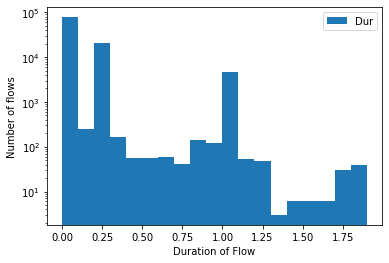

In [154]:
df['Dur'] = df["Dur"].astype(float)

plt.hist([df['Dur']],log=True,bins = np.arange(0,2,0.1), label=['Dur'])
plt.ylabel('Number of flows')
plt.xlabel('Duration of Flow')
plt.legend()
plt.show()

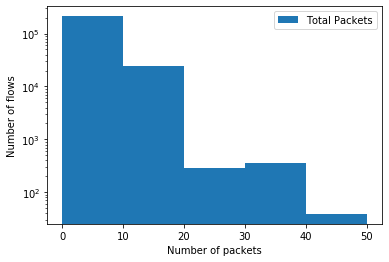

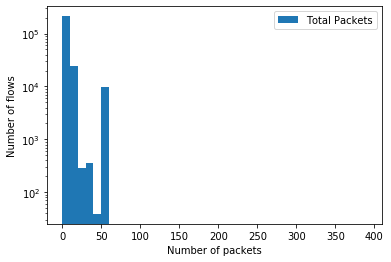

In [155]:

plt.hist([df['TotPkts']],log=True,bins = np.arange(0,max(df['TotPkts']),10), label=['Total Packets'])
plt.ylabel('Number of flows')
plt.xlabel('Number of packets')
plt.legend()
plt.show()

plt.cla()

plt.hist([df['TotPkts']],log=True,bins = np.arange(0,400,10), label=['Total Packets'])
plt.ylabel('Number of flows')
plt.xlabel('Number of packets')
plt.legend()
plt.show()

Text(0.5, 1.0, 'Top 10 IP addresses by traffic volume')

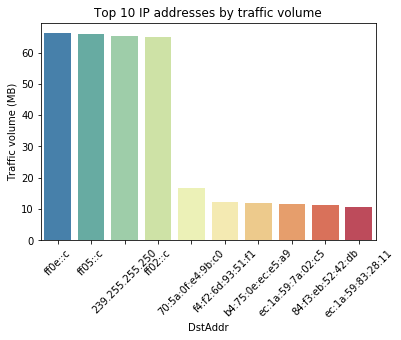

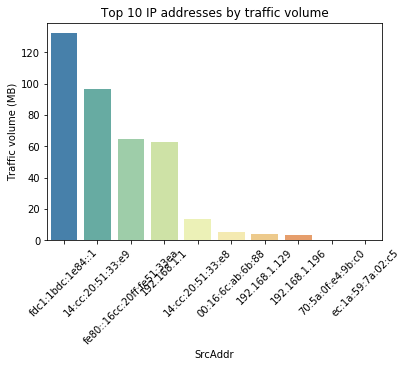

In [156]:
f, ax = plt.subplots(1, 1,figsize=(6, 4))

per_ip = df.groupby("DstAddr", as_index=False).agg({"TotBytes":[np.sum]})

p = per_ip.sort_values(by=("TotBytes","sum"),ascending=False)[:10]
p["TotBytes","sum"] = p["TotBytes","sum"]/1000000
sns.barplot(p["DstAddr"], p["TotBytes","sum"],palette="Spectral_r", ax=ax)

ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=45)
ax.set_ylabel("Traffic volume (MB)")
ax.set_title("Top 10 IP addresses by traffic volume")

f, ax = plt.subplots(1, 1,figsize=(6, 4))

per_ip = df.groupby("SrcAddr", as_index=False).agg({"TotBytes":[np.sum]})

p = per_ip.sort_values(by=("TotBytes","sum"),ascending=False)[:10]
p["TotBytes","sum"] = p["TotBytes","sum"]/1000000
sns.barplot(p["SrcAddr"], p["TotBytes","sum"],palette="Spectral_r", ax=ax)

ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=45)
ax.set_ylabel("Traffic volume (MB)")
ax.set_title("Top 10 IP addresses by traffic volume")


Text(0.5, 1.0, 'Top 10 IP addresses by traffic volume')

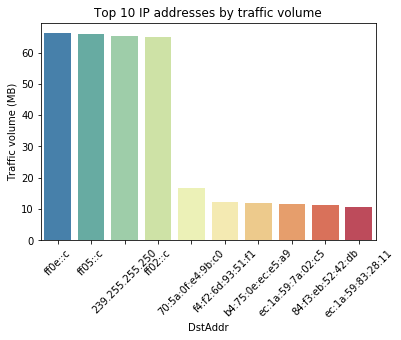

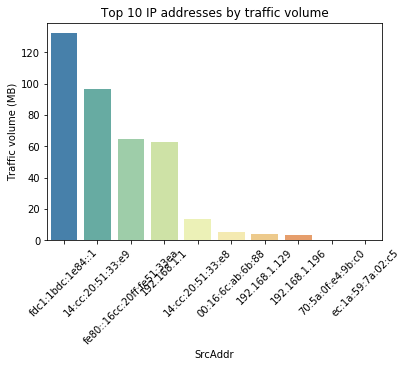

In [157]:
f, ax = plt.subplots(1, 1,figsize=(6, 4))

per_ip = df.groupby("DstAddr", as_index=False).agg({"TotBytes":[np.sum]})

p = per_ip.sort_values(by=("TotBytes","sum"),ascending=False)[:10]
p["TotBytes","sum"] = p["TotBytes","sum"]/1000000
sns.barplot(p["DstAddr"], p["TotBytes","sum"],palette="Spectral_r", ax=ax)

ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=45)
ax.set_ylabel("Traffic volume (MB)")
ax.set_title("Top 10 IP addresses by traffic volume")

f, ax = plt.subplots(1, 1,figsize=(6, 4))

per_ip = df.groupby("SrcAddr", as_index=False).agg({"TotBytes":[np.sum]})

p = per_ip.sort_values(by=("TotBytes","sum"),ascending=False)[:10]
p["TotBytes","sum"] = p["TotBytes","sum"]/1000000
sns.barplot(p["SrcAddr"], p["TotBytes","sum"],palette="Spectral_r", ax=ax)

ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=45)
ax.set_ylabel("Traffic volume (MB)")
ax.set_title("Top 10 IP addresses by traffic volume")


Text(0.5, 1.0, 'IP addresses by traffic Rate')

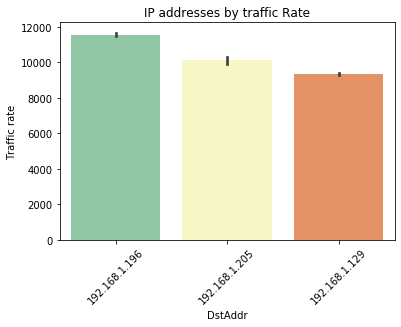

In [158]:
f, ax = plt.subplots(1, 1,figsize=(6, 4))

per_ip = df.groupby("DstAddr", as_index=False).agg({"Rate":[np.sum]})

p = df.sort_values(by=("Rate"),ascending=False)[:1000]
# p["Rate","sum"] = p["Rate","sum"]/1000000
sns.barplot(p["DstAddr"], p["Rate"],palette="Spectral_r", ax=ax)

ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=45)
ax.set_ylabel("Traffic rate")
ax.set_title("IP addresses by traffic Rate")

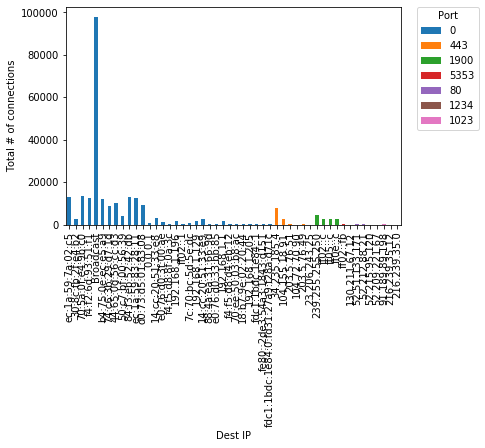

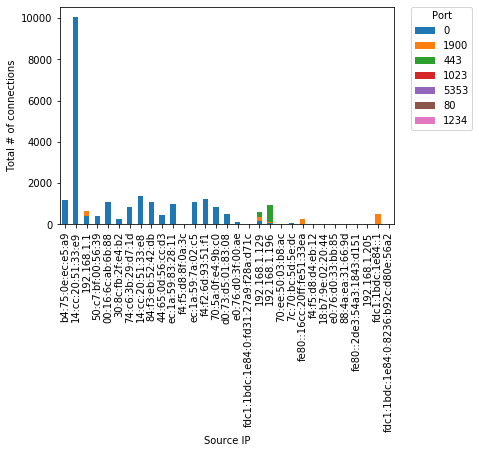

In [162]:
def box_plot_df_setup(series_a, series_b): 
    # Count up all the times that a category from series_a
    # matches up with a category from series_b. This is
    # basically a gigantic contingency table
    cont_table = collections.defaultdict(lambda : collections.Counter())
    for val_a, val_b in zip(series_a.values, series_b.values):
        cont_table[val_a][val_b] += 1
    
    # Create a dataframe
    # A dataframe with keys from series_a as the index, series_b_keys
    # as the columns and the counts as the values.
    dataframe = pd.DataFrame(cont_table.values(), index=cont_table.keys())
    dataframe.fillna(0, inplace=True)
    return dataframe

df1 = df

per_port = df1.groupby("DstAddr", as_index=False).agg({"TotBytes":[np.sum]})

# print(per_port)
p = per_port.sort_values(by=("TotBytes","sum"),ascending=False)[:50]

array = p['DstAddr']
# array
df1 = df1.loc[df1['DstAddr'].isin(array)]

ax = box_plot_df_setup(df1['Dport'], df1["DstAddr"]).T.plot(kind='bar', stacked=True)

plt.ylabel('Total # of connections')
plt.xlabel('Dest IP')
patches, labels = ax.get_legend_handles_labels()
ax.legend(patches, labels, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., title="Port")

df1 = df.sample(frac=0.1, random_state=10)

per_port = df1.groupby("Dport", as_index=False).agg({"TotBytes":[np.sum]})

# print(per_port)
p = per_port.sort_values(by=("TotBytes","sum"),ascending=False)[:20]

array = p['Dport']
# array
df1 = df1.loc[df1['Dport'].isin(array)]

ax = box_plot_df_setup(df1['Dport'], df1['SrcAddr']).T.plot(kind='bar', stacked=True)
plt.ylabel('Total # of connections')
plt.xlabel('Source IP')
patches, labels = ax.get_legend_handles_labels()
ax.legend(patches, labels, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., title="Port")

### Import benign data

In [59]:
filepath = '/home/faizan/dalhousie/181021-3.csv'
attack_flows = pd.read_csv(filepath, index_col=None, delimiter=',')


attack_flows


,StartTime,Dur,Flgs,Proto,SrcAddr,Sport,Dir,DstAddr,Dport,TotPkts,...,DIntPktIdl,SrcJitter,DstJitter,sMeanPktSz,dMeanPktSz,sMaxPktSz,dMaxPktSz,sMinPktSz,dMinPktSz,Label
0,1.540040e+09,4.066716,e,eapol,14:cc:20:51:33:e9,NaN,<->,ec:1a:59:7a:02:c5,NaN,6,...,0.0,1028.698500,1025.152500,113.0,137.0,113.0,137.0,113.0,137.0,NaN
1,1.540040e+09,2.759746,e,eapol,14:cc:20:51:33:e8,NaN,<->,30:8c:fb:2f:e4:b2,NaN,5,...,0.0,621.083000,0.000000,135.0,113.0,135.0,113.0,135.0,113.0,NaN
2,1.540040e+09,4.406374,e,eapol,14:cc:20:51:33:e9,NaN,<->,70:5a:0f:e4:9b:c0,NaN,8,...,0.0,410.688281,417.422469,113.0,135.0,113.0,135.0,113.0,135.0,NaN
3,1.540040e+09,4.993716,e,eapol,14:cc:20:51:33:e9,NaN,<->,f4:f2:6d:93:51:f1,NaN,5,...,0.0,496.311000,0.000000,113.0,135.0,113.0,135.0,113.0,135.0,NaN
4,1.540040e+09,0.000000,*,llc,b4:75:0e:ec:e5:a9,0x01,->,Broadcast,NaN,1,...,NaN,NaN,NaN,20.0,0.0,20.0,NaN,20.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
247015,1.540065e+09,0.000000,*,llc,84:f3:eb:52:42:db,0x01,->,Broadcast,NaN,1,...,0.0,0.000000,NaN,20.0,0.0,20.0,NaN,20.0,NaN,NaN
247016,1.540065e+09,0.005716,e,eapol,14:cc:20:51:33:e9,NaN,<->,84:f3:eb:52:42:db,NaN,2,...,0.0,0.000000,0.000000,113.0,135.0,113.0,135.0,113.0,135.0,NaN
247017,1.540065e+09,0.003416,e,eapol,14:cc:20:51:33:e8,NaN,<->,44:65:0d:56:cc:d3,NaN,2,...,0.0,0.000000,0.000000,113.0,135.0,113.0,135.0,113.0,135.0,NaN
247018,1.540065e+09,0.000000,*,llc,70:5a:0f:e4:9b:c0,0x01,->,Broadcast,NaN,1,...,0.0,0.000000,NaN,20.0,0.0,20.0,NaN,20.0,NaN,NaN


In [60]:
df=attack_flows.fillna(0)

def convert_to_int(x):
    if x == 0:
        return x
    elif x.isnumeric():
        return int(x)
    elif x=='http':
        return 80
    elif x=='https':
        return 443
    elif x=='ntp':
        return 1023
    elif x=='mdns':
        return 5353
    elif x=='bootps':
        return 1234
    return 0

df['Dport']=df['Dport'].apply(convert_to_int)
df['Sport']=df['Sport'].apply(convert_to_int)

In [61]:
def convert_string_to_int(x):
    return abs(hash(x)) % (10 ** 10)
    
string_features = ['Dir', 'DstAddr', 'SrcAddr', 'DstMac']

for sf in string_features:
    df[sf]=df[sf].apply(convert_string_to_int)

In [62]:
df['SrcAddr']

0         1193645106
1         9063950555
2         1193645106
3         1193645106
4         9629853443
             ...    
247015    4732742772
247016    1193645106
247017    9063950555
247018    7913910941
247019    1193645106
Name: SrcAddr, Length: 247020, dtype: int64

In [63]:
# Features which will not be used
pointless_features = ['Label', 'Dur.1','Flgs.1','Proto.1','SrcAddr.1','SrcMac',
                      'Sport.1','Dir.1','DstAddr.1','TotPkts.1','TotBytes.1', 'Dport.1']

# # Non-decimal features categorized by data-type
# hex_features = ['flowStat', 'tcpFStat', 'ipTOS', 'ipFlags', 'ethType',
#                  'tcpStates', 'icmpStat', 'icmpTmGtw', 'macStat','tcpAnomaly', 
#                 'tcpFlags',  'tcpMPF', 'tcpMPTBF', 'tcpMPdssF', 'tcpOptions']


string_features = ['Proto', 'Flgs', 'State']

# # Not sure what to make of these - more research required
# underscore_features = ['ethVlanID','ipOptCpCl_Num', 'icmpBFTypH_TypL_Code', 'ip6OptHH_D', 'ip6OptCntHH_D']

# # Features we will use
# features = ['flowInd', 'duration', 'numHdrDesc', 'numHdrs',
#              'l4Proto', 'macPairs', 'dstPortClassN', 'numPktsSnt', 'numPktsRcvd',
#             'numBytesSnt', 'numBytesRcvd', 'minPktSz', 'maxPktSz', 'avePktSize', 'stdPktSize', 'pktps', 'bytps',
#             'pktAsm', 'bytAsm', 'ipMindIPID', 'ipMaxdIPID', 'ipMinTTL', 'ipMaxTTL', 'ipTTLChg', 'ipOptCnt',
#             'tcpPSeqCnt', 'tcpSeqSntBytes', 'tcpSeqFaultCnt', 'tcpPAckCnt', 'tcpFlwLssAckRcvdBytes', 'tcpAckFaultCnt',
#             'tcpInitWinSz', 'tcpAveWinSz', 'tcpMinWinSz', 'tcpMaxWinSz', 'tcpWinSzDwnCnt', 'tcpWinSzUpCnt',
#             'tcpWinSzChgDirCnt', 'tcpOptPktCnt', 'tcpOptCnt', 'tcpMSS', 'tcpWS', 'tcpTmS', 'tcpTmER', 'tcpEcI',
#             'tcpBtm', 'tcpSSASAATrip', 'tcpRTTAckTripMin', 'tcpRTTAckTripMax', 'tcpRTTAckTripAve',
#             'tcpRTTAckTripJitAve', 'tcpRTTSseqAA', 'tcpRTTAckJitAve', 'icmpTCcnt', 'icmpEchoSuccRatio', 'icmpPFindex',
#             'connSip', 'connDip', 'connSipDip', 'connSipDprt', 'connF',  'aveIAT', 'maxIAT', 
#                 'minIAT', 'stdIAT', 'tcpISeqN', 'tcpMPAID', 'tcpUtm', 'tcpWinSzThRt']
df = df.drop(pointless_features+string_features, axis = 1)
# unused_features = pointless_features + hex_features + string_features + underscore_features
# all_features = features + unused_features

# attack_flows[features]

In [64]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 247020 entries, 0 to 247019
Data columns (total 46 columns):
StartTime     247020 non-null float64
Dur           247020 non-null float64
SrcAddr       247020 non-null int64
Sport         247020 non-null int64
Dir           247020 non-null int64
DstAddr       247020 non-null int64
Dport         247020 non-null int64
TotPkts       247020 non-null int64
TotBytes      247020 non-null int64
DstMac        247020 non-null int64
RunTime       247020 non-null float64
Mean          247020 non-null float64
Sum           247020 non-null float64
Min           247020 non-null float64
Max           247020 non-null float64
sTos          247020 non-null float64
dTos          247020 non-null float64
SrcPkts       247020 non-null int64
DstPkts       247020 non-null int64
sTtl          247020 non-null float64
dTtl          247020 non-null float64
TotAppByte    247020 non-null int64
SAppBytes     247020 non-null int64
DstBytes      247020 non-null int64
DAp

In [65]:
import sys
import os
import glob
print(sys.version_info)
import pandas as pd
import numpy as np
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
import collections

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix,classification_report

sys.version_info(major=3, minor=7, micro=5, releaselevel='final', serial=0)


In [71]:
attack_flows = df
from sklearn.preprocessing import StandardScaler
x = attack_flows.loc[::].values
x = StandardScaler().fit_transform(x) # normalizing the features
np.mean(x),np.std(x), len(x)

(8.35429349745007e-13, 0.9890707100936806, 247020)

In [67]:
from sklearn.decomposition import PCA
pca_attack = PCA(n_components=10)
principalComponents_attack = pca_attack.fit_transform(x)

principal_attack_Df = pd.DataFrame(data = principalComponents_attack
             , columns = ['principal component 1', 'principal component 2',
                         'principal component 3', 'principal component 4',
                         'principal component 5', 'principal component 6',
                         'principal component 7', 'principal component 8',
                         'principal component 9', 'principal component 10'])
principal_attack_Df.tail()

,principal component 1,principal component 2,principal component 3,principal component 4,principal component 5,principal component 6,principal component 7,principal component 8,principal component 9,principal component 10
247015,-3.229771,-3.070049,-0.972647,0.547373,0.440318,0.257219,-0.126150,-0.547391,-1.708224,-0.227235
247016,0.243873,-0.326242,-0.023916,3.612094,0.517872,-0.008374,-0.751522,-1.131599,-1.678418,-0.275056
247017,-0.930595,-0.545072,0.414980,2.619068,-0.687625,0.441267,-0.560925,0.322788,-1.746064,-0.155678
247018,-3.239198,-2.851198,-0.652003,0.540064,0.150339,0.221352,-0.092635,0.021897,-1.733294,-0.269246
247019,-0.489220,-0.576315,0.319476,2.745465,-0.884379,1.353747,-1.179502,-0.670034,-1.724210,0.374567


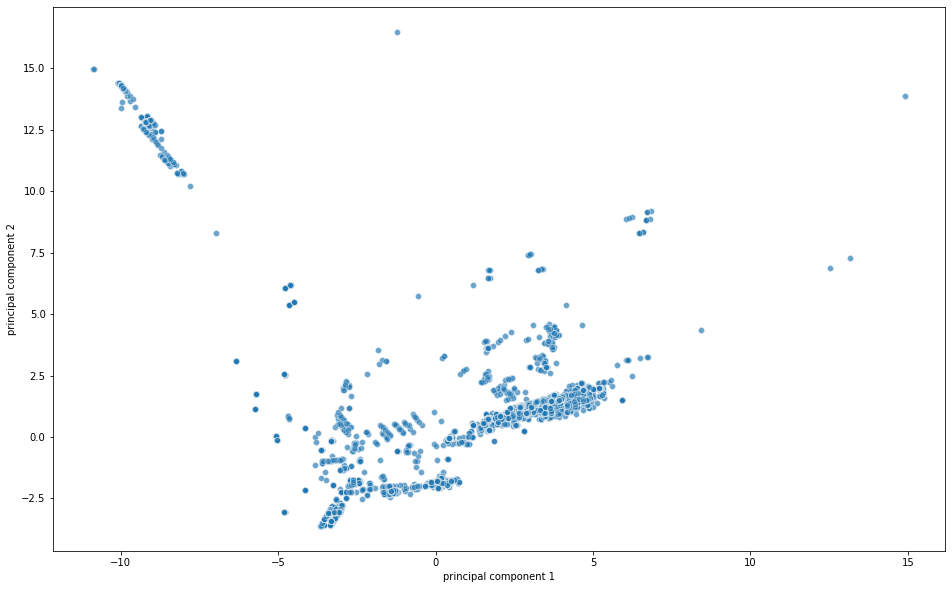

In [68]:
import seaborn as sns
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="principal component 1", y="principal component 2",
    palette=sns.color_palette("hls", 10),
    data=principal_attack_Df,
    legend="full",
    alpha=0.3
)

In [72]:
principal_attack_Df

,principal component 1,principal component 2,principal component 3,principal component 4,principal component 5,principal component 6,principal component 7,principal component 8,principal component 9,principal component 10
0,3.667660,1.010830,0.177896,-1.012981,-0.411254,1.583771,-0.840223,-0.403074,1.745837,0.006204
1,1.521980,0.648154,0.133491,-0.215108,-0.459794,0.511324,-0.325828,0.307884,1.712639,0.028483
2,3.831137,1.295206,0.037051,-1.128557,-1.104034,0.962932,-0.455263,-0.136655,1.725777,0.434967
3,3.973540,1.262917,-0.945401,-0.698294,0.376223,-2.979322,1.278996,0.407616,1.711674,0.609252
4,-3.017798,-2.252663,0.014700,0.891196,-0.765387,0.133419,-0.173108,1.212096,1.664940,0.247361
...,...,...,...,...,...,...,...,...,...,...
247015,-3.229771,-3.070049,-0.972647,0.547373,0.440318,0.257219,-0.126150,-0.547391,-1.708224,-0.227235
247016,0.243873,-0.326242,-0.023916,3.612094,0.517872,-0.008374,-0.751522,-1.131599,-1.678418,-0.275056
247017,-0.930595,-0.545072,0.414980,2.619068,-0.687625,0.441267,-0.560925,0.322788,-1.746064,-0.155678
247018,-3.239198,-2.851198,-0.652003,0.540064,0.150339,0.221352,-0.092635,0.021897,-1.733294,-0.269246
